#  Car Pplate Detector 

> PART 4 / DETECT PLATES PRECENCE,COLOR,CORDINATES


<img src="/Users/adrian/Desktop/PY-PROJECTS/Machine_Learning/cart-plate-detector/fonts/img/img3.png" style="width:400px;height 400px"/>


     x [WxH] ---> MODEL ---> Y[presence,xs,ys,xe,ye,plates_color]

     xs -- x start
     xe -- x end

In [18]:
import os
from sys import  getsizeof
from random import randint

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image,ImageOps, ImageDraw,ImageFont

import numpy as np

import torch, torch.nn as nn, torch.optim as optim

# Generating DATA SETS

In [19]:
file_names = os.listdir('images')

file_count = 0

CAM_SIZE   = (600,600)
IMG_SIZE   = (150,150)
FONT_SIZE  = (5,9)
CHARS      = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-. "
COLORS     = ['black','white']

# BLACK -> 0 , WHITE -> 1
data_x = None
data_y = None

for file_name in file_names:
    if file_name[-7:] == '3.0.jpg':
        # print(file_name)

        for variant in range(5):
            img = Image.open('images' + "/" + file_name)
            img = ImageOps.grayscale(img)
            img = img.resize(IMG_SIZE)
            font_size_ = randint(*FONT_SIZE)
            font       = ImageFont.truetype('fonts/arial.ttf', font_size_)

            pad = 2
            chars_len= randint(4,7)
            
            w = 2 * pad + int(font_size_ * chars_len * .75)
            h = 2 * pad + font_size_

            xs,ys = randint(0,IMG_SIZE[0]-w),randint(0,IMG_SIZE[1]-w)
            
            plate_number = "".join( [ CHARS[randint(0,len(CHARS) - 1)] for i in range(chars_len) ] )
            plate_color  = randint(0,1)
            text_color   =  1 - plate_color

            draw = ImageDraw.Draw(img)
            has_plate =  randint(0,10) < 9
            if has_plate:
             
                draw.rectangle((xs,ys, xs + w, ys + h), fill = COLORS[plate_color])
                draw.text((xs+pad,ys+pad),plate_number,  COLORS[text_color], font=font)

            # plt.figure()
            # plt.imshow(img,cmap="gray")
            x_matrix = np.array(img, dtype=np.float32)
            x_matrix /= 255.0 # normalize vs black..White -> 0..1
            y_vector = np.array([
                has_plate,
                xs / IMG_SIZE[0],
                ys / IMG_SIZE[1],
                (xs + w) / IMG_SIZE[0],
                (ys + h) / IMG_SIZE[1],
                plate_color
            ])

            if file_count == 0 and variant == 0:
                data_x = np.array([x_matrix])
                data_y = np.array([y_vector])
            else:
                data_x = np.append(data_x,[x_matrix], axis=0)
                data_y = np.append(data_y,[y_vector], axis=0)
        file_count += 1
        if file_count >= 50:
            break
print("generated data sets with:")    
print(data_x.shape)
print(data_y.shape)
# print(data_x)         

generated data sets with:
(250, 150, 150)
(250, 6)


[[0.28235295 0.2901961  0.28627452 ... 0.5294118  0.5294118  0.52156866]
 [0.28627452 0.29411766 0.2901961  ... 0.53333336 0.53333336 0.5294118 ]
 [0.29411766 0.29803923 0.29803923 ... 0.5372549  0.5411765  0.5411765 ]
 ...
 [0.07843138 0.07058824 0.07058824 ... 0.13725491 0.14117648 0.12941177]
 [0.07058824 0.06666667 0.07058824 ... 0.15294118 0.13725491 0.13725491]
 [0.08627451 0.07450981 0.07450981 ... 0.1254902  0.13333334 0.13725491]]
[0.         0.59333333 0.4        0.88666667 0.48666667 0.        ]


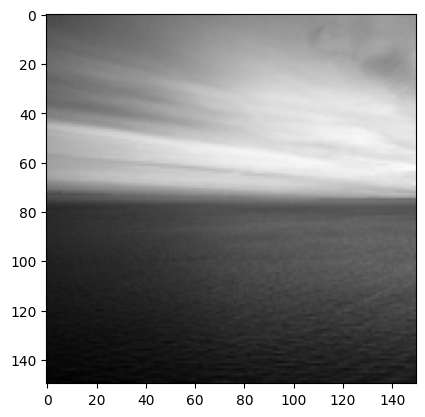

In [20]:
rand_index =  randint(0,data_x.shape[0]-1)
plt.figure()
plt.imshow(data_x[rand_index],cmap="gray")
print(data_x[rand_index])
print(data_y[rand_index])

## Built the model

In [21]:
model= nn.Sequential(
    nn.Conv2d(in_channels= 1, out_channels= 32, kernel_size= (5,5)),
    nn.MaxPool2d(kernel_size=(5,5)),
    nn.Flatten(start_dim=0),
    nn.Sigmoid(),
    nn.Linear(in_features= 26912, out_features= 6)
)

## Training Loop


In [60]:
criterion= nn.MSELoss()            # THIS IS REGRETION
optimizer= optim.SGD(model.parameters(), lr= 0.005)


for epoch in range(1,201):
    avg_loss= 0 
    for i in range(len(data_x)):
        
        x= torch.from_numpy(data_x[i]).type(torch.FloatTensor).view(1,*IMG_SIZE)
        y= torch.from_numpy(data_y[i]).type(torch.FloatTensor)

        optimizer.zero_grad()
        yp= model(x)
        # print(yp)
        # break

        loss= criterion(yp,y)
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
    # break    
    
    avg_loss /= len(data_x)
    print(f"epoch {epoch:5} loss = {avg_loss:15.6f}")




# print(y.shape)
# print(y)

epoch     1 loss =        0.147347
epoch     2 loss =        0.146826
epoch     3 loss =        0.146316
epoch     4 loss =        0.145815
epoch     5 loss =        0.145324
epoch     6 loss =        0.144842
epoch     7 loss =        0.144369
epoch     8 loss =        0.143906
epoch     9 loss =        0.143451
epoch    10 loss =        0.143004
epoch    11 loss =        0.142565
epoch    12 loss =        0.142135
epoch    13 loss =        0.141712
epoch    14 loss =        0.141296
epoch    15 loss =        0.140888
epoch    16 loss =        0.140487
epoch    17 loss =        0.140093
epoch    18 loss =        0.139706
epoch    19 loss =        0.139325
epoch    20 loss =        0.138951
epoch    21 loss =        0.138582
epoch    22 loss =        0.138221
epoch    23 loss =        0.137865
epoch    24 loss =        0.137514
epoch    25 loss =        0.137170
epoch    26 loss =        0.136831
epoch    27 loss =        0.136497
epoch    28 loss =        0.136169
epoch    29 loss =  

[0.70373315 0.37838215 0.3204397  0.5872165  0.4662842  0.42937753]


<Figure size 640x480 with 0 Axes>

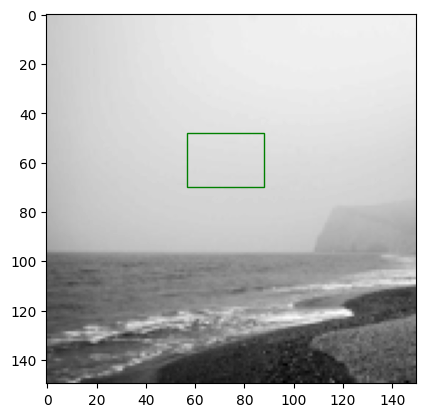

In [108]:
rand_index =  randint(0,data_x.shape[0] -1)
plt.figure()

fig, ax = plt.subplots()

ax.imshow(data_x[rand_index], cmap='gray')

x= torch.from_numpy(data_x[rand_index]).type(torch.FloatTensor).view(1,*IMG_SIZE)
y= torch.from_numpy(data_y[rand_index]).type(torch.FloatTensor)
yp= model(x)
yp= yp.detach().numpy()

rect= patches.Rectangle(
    (yp[1]*IMG_SIZE[0], yp[2] * IMG_SIZE[1]),
    (yp[3] - yp[1]) * IMG_SIZE[0],
    (yp[4] - yp[2]) * IMG_SIZE[1],
    linewidth = 1,
    edgecolor = "g", 
    facecolor = "None"
)
ax.add_patch(rect)

print(yp)
